# OpenCV 中的图像处理
## 颜色空间转换
BGR$\leftrightarrow$Gray   
    BGR$\leftrightarrow$HSV     H（色彩/色度）的取值范围是 [0， 179]，S（饱和度）的取值范围 [0， 255]， V（亮度）的取值范围 [0， 255],   
    不同软件的HSV取值可能不同，需要注意归一化

 **cv2.cvtColor(input_image， flag)**  
 flag 就是转换的类型

In [181]:
import cv2
import numpy as np
import copy as cp
flags=[];
for i in dir(cv2):
        if i.startswith('COLOR_'):
            flags.append(i)
#print (flags)

In [88]:
from matplotlib import pyplot as plt
def imdisp(img,winName,sizeflag=cv2.WINDOW_NORMAL):
    if sizeflag==1:
        sizeflag=cv2.WINDOW_AUTOSIZE
    cv2.namedWindow(winName,sizeflag)
    cv2.imshow(winName,img) 
    cv2.waitKey(0)
    cv2.destroyWindow(winName)

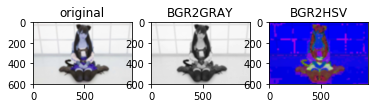

In [3]:
img1=cv2.imread('../images/yaorenmao.jpeg')
ImaGray=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
ImaHSV=cv2.cvtColor(img1,cv2.COLOR_BGR2HSV)
plt.subplot(131), plt.imshow(img1,interpolation='bicubic'),plt.title('original')
plt.subplot(132), plt.imshow(ImaGray, cmap='gray',interpolation='bicubic'),plt.title('BGR2GRAY')
plt.subplot(133), plt.imshow(ImaHSV,interpolation='bicubic'),plt.title('BGR2HSV')
plt.show()
imdisp(ImaHSV,'BGR2HSV')


HSV 可以更好表现颜色，可以用来提取**图片中特定颜色的部分**

In [67]:
#  获取所需要颜色的HSV数值
red=np.uint8([[[75,50,176]]])
hsv_red=cv2.cvtColor(red,cv2.COLOR_BGR2HSV)
hsv_red
#scn (the number of channels of the source),
#i.e. self.img.channels(), is neither 3 nor 4.
#
#depth (of the source),
#i.e. self.img.depth(), is neither CV_8U nor CV_32F.
# 所以不能用 [0,255,0]，而要用 [[[0,255,0]]]
# 这里的三层括号应该分别对应于 cvArray， cvMat， IplImage

array([[[174, 183, 176]]], dtype=uint8)

In [77]:
# 设定蓝色的阈值
lower_blue=np.array(hsv_red.reshape(3,)-20)
upper_blue=np.array(hsv_red.reshape(3,)+20)
# 根据阈值构建掩模
mask=cv2.inRange(ImaHSV,lower_blue,upper_blue)
# 对原图像和掩模进行位运算
res=cv2.bitwise_and(img1,img1,mask=mask)
imdisp(res,'red-skirt')

## 几何变换
### 伸缩缩放
**Resize(src, dst, interpolation=CV_INTER_LINEAR)**  
插值：  
缩小： v2.INTER_AREA  
放大：  v2.INTER_CUBIC（慢) 和 v2.INTER_LINEAR（默认）


<font size='6' color='red'>变换后的坐标还是原来图片的坐标， 即使是平移也会导致图片变大， 继续维持原大小会只有变换后的图片落在原始图片内的部分</font>

In [116]:
# 缩放因子
res=cv2.resize(img1,None,fx=2,fy=2,interpolation=cv2.INTER_CUBIC)
imdisp(res, 'enlarge 2*2',1)
# 指定大小，不需要缩放因子
height,width=img1.shape[:2]
res=cv2.resize(img1,(int(0.2*width),int(0.2*height)),interpolation= cv2.INTER_AREA)
imdisp(res, 'resize 0.2*0.2',1)

### 平移
**cv2.warpAffine()<---------- 2x3的M**  
** cv2.warpPerspective()<---------- 3x3的M **
$$
M=
\left[
  \begin{array}{ccc}
    1 & 0 & t_x\\
    0 & 1 & t_y \\
  \end{array}
\right]$$
将平移矩阵$M$（np.float32） 传入  


横是x[1], 竖是y[0],   
高，宽，通道，[行[列]]  
图像尺寸定义： 宽（列），高（行）  


In [161]:
M=np.float32([[1,0,50],[0,1,100]])
height,width=img1.shape[:2]
sima=cv2.warpAffine(img1,M,(width+50,height+100))
imdisp(sima,'shift',1)

### 旋转

opencv允许在任何地方旋转
$$
M=
\left[
  \begin{array}{ccc}
    \alpha & \beta& (1-\alpha)*x_{center}-\beta*y_{center}\\
    -\beta & \alpha & \beta*x_{center}+(1-\alpha)*x_{center} \\
  \end{array}
\right]\\
\alpha=scale*\cos(\theta)\\
\beta=scale*\sin(\theta)
$$

**cv2.getRotationMatrix2D**来构建这个旋转矩阵

In [174]:
rows,cols=img1.shape[:2]
# 这里的第一个参数为旋转中心，第二个为逆时针旋转角度，第三个为旋转后的缩放因子
# 可以通过设置旋转中心，缩放因子，以及窗口大小来防止旋转后超出边界的问题
M=cv2.getRotationMatrix2D((cols/2,rows/2),30,1)



In [179]:
Rima=cv2.warpAffine(img1,M,(cols,rows*2))
M=np.float32([[1,0,50],[0,1,100]])
sRima=cv2.warpAffine(Rima,M,(cols,rows*2))
imdisp(sRima,'rotation',1)

###  仿射变换
知道原图中的点（3个）与变换后的点的坐标，来变换整张图  , 变换后平行线还是平行线
**cv2.getAffineTransform(oripts,trapts)**

In [205]:
oripts=np.float32([[50,50],[200,50],[50,200]])
trapts=np.float32([[10,100],[200,50],[100,250]])
M=cv2.getAffineTransform(oripts,trapts)
M

array([[  1.26666667,   0.6       , -83.33333333],
       [ -0.33333333,   1.        ,  66.66666667]])

In [208]:
dst=cv2.warpAffine(img1,M,(cols,rows))
imdisp(dst,'affine',1)



### 透视变换
四个点中的任意三个都不能共线， 在变换前后直线还是直线

In [210]:
pts1 = np.float32([[56,65],[368,52],[28,387],[389,390]])
pts2 = np.float32([[0,0],[300,0],[0,300],[300,300]])
M=cv2.getPerspectiveTransform(pts1,pts2)
M

array([[ 1.05587376e+00,  9.18151097e-02, -6.50969128e+01],
       [ 4.69010049e-02,  1.12562412e+00, -7.57920240e+01],
       [ 1.83251448e-04,  5.13337001e-04,  1.00000000e+00]])

In [211]:
dst=cv2.warpPerspective(img1,M,(cols,rows))
imdisp(dst,'toushi')

## 阈值处理
## 简单阈值
超过阈值赋予新值  
retVal, img=cv2.threshhold(原灰度图像，阈值，新值，阈值方法)

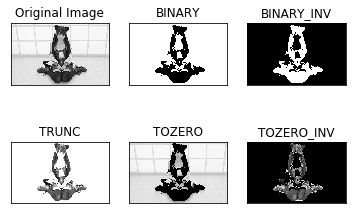

In [249]:
img=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)

ret,thresh1=cv2.threshold(img,127,255,cv2.THRESH_BINARY) # 高于127给255， 二值化[0,255]
ret,thresh2=cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3=cv2.threshold(img,127,255,cv2.THRESH_TRUNC)# 高于127为127，小于不变
ret,thresh4=cv2.threshold(img,127,255,cv2.THRESH_TOZERO)# 高于127为0，小于不变
ret,thresh5=cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)# 小于127为0，小于不变
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

### 自适应阈值
根据图像上的每一个小区域计算与其对应的阈值  **cv2.adaptiveThreshold**

- Adaptive Method- 指定计算阈值的方法。
     - cv2.ADPTIVE_THRESH_MEAN_C：阈值取自相邻区域的平均值
     - cv2.ADPTIVE_THRESH_GAUSSIAN_C：阈值取值相邻区域的加权和，权重为一个高斯窗口。
- Block Size      邻域大小（用来计算阈值的区域大小）。
-  C   这就是是一个常数，阈值就等于的平均值或者加权平均值减去这个常数。


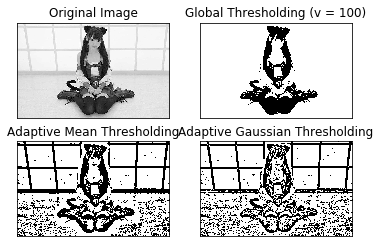

In [250]:
ret,th1 = cv2.threshold(img,100,255,cv2.THRESH_BINARY)
#11 为 Block size, 2 为 C 值
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
cv2.THRESH_BINARY,51,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
cv2.THRESH_BINARY,51,2)
titles = ['Original Image', 'Global Thresholding (v = 100)',
'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

### Otsu’s 二值化
**cv2.threshold()**
**（flag）： cv2.THRESH_OTSU。这时要把阈值设为 0。**   
不采用大津法的话， retVal 与设定的阈值一致

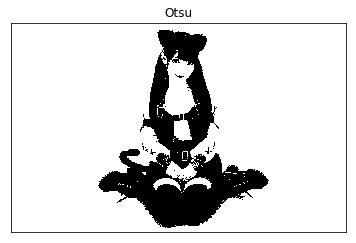

In [231]:
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(th2,'gray')
plt.title('Otsu')
plt.xticks([]),plt.yticks([])
plt.show()

## 图像平滑
### 均值滤波
核的宽和高必须是奇数

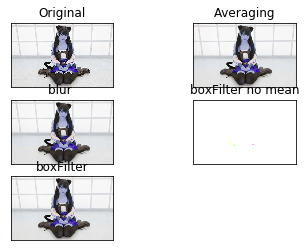

In [239]:
kernel = np.ones((5,5),np.float32)/25

dst = cv2.filter2D(img1,-1,kernel)
#when ddepth=-1, the output image will have the same depth as the source.
#src.depth() = CV_8U, ddepth = -1/CV_16S/CV_32F/CV_64F
#src.depth() = CV_16U/CV_16S, ddepth = -1/CV_32F/CV_64F
#src.depth() = CV_32F, ddepth = -1/CV_32F/CV_64F
#src.depth() = CV_64F, ddepth = -1/CV_64F

blur = cv2.blur(img1,(5,5))# 均值
boxF=cv2.boxFilter(img1,-1,(5,5),normalize=False)# 不处以25
boxFm=cv2.boxFilter(img1,-1,(5,5),)# 均值

plt.subplot(321),plt.imshow(img1),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(322),plt.imshow(dst),plt.title('Averaging')
plt.xticks([]), plt.yticks([])
plt.subplot(323),plt.imshow(blur ),plt.title('blur ')
plt.xticks([]), plt.yticks([])
plt.subplot(324),plt.imshow(boxF),plt.title('boxFilter no mean')
plt.xticks([]), plt.yticks([])
plt.subplot(325),plt.imshow(boxFm),plt.title('boxFilter')
plt.xticks([]), plt.yticks([])
plt.show()

### 高斯模糊
我们需要指定高斯核的宽和高（必须是奇数）。以及高斯函数沿 X， Y 方向的标准差。  
如果我们只指定了 X 方向的的标准差， Y 方向也会取相同值。如果两个标准差都是 0，那么函数会根据核函数的大小自己计算  
**cv2.getGaussianKernel() **自己构建一个高斯核

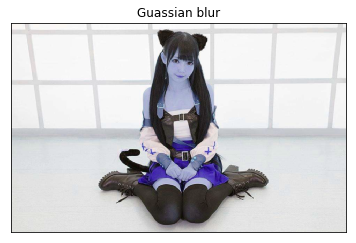

In [240]:
blur = cv2.GaussianBlur(img1,(5,5),0)# 0为该高斯核根据核尺寸自己计算
plt.imshow(blur),plt.title('Guassian blur'),plt.xticks([]), plt.yticks([])
plt.show()

### 中值模糊 
尺寸只需要指定一个数

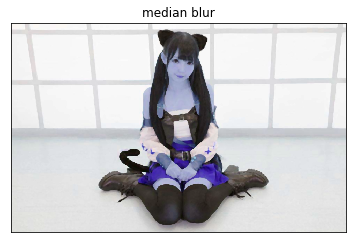

In [243]:
median = cv2.medianBlur(img1,5)
plt.imshow(median),plt.title('median blur'),plt.xticks([]), plt.yticks([])
plt.show()

### 双边滤波  
<font size="4" color='blue'>不会模糊掉边界</font>  
双边滤波在同时使用**空间高斯权重**和**灰度值相似性高斯权重**。  
空间高斯函数确保只有邻近区域的像素对中心点有影响，  
灰度值相似性高斯函数确保只有与中心像素灰度值相近的才会被用来做模糊运算。  
所以这种方法会确保边界不会被模糊掉，因为边界处的灰度值变化比较大。

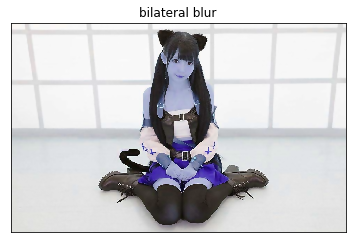

In [244]:
#cv2.bilateralFilter(src, d, sigmaColor, sigmaSpace)
#d – Diameter of each pixel neighborhood that is used during filtering.
# If it is non-positive, it is computed from sigmaSpace
#9 邻域直径，两个 75 分别是空间高斯函数标准差，灰度值相似性高斯函数标准差
blur = cv2.bilateralFilter(img1,9,75,75)
plt.imshow(blur),plt.title('bilateral blur'),plt.xticks([]), plt.yticks([])
plt.show()

##  图像梯度
- Sobel（使用小的卷积核求解求解梯度角度时）
- Scharr 优化的Sobel
- Laplacian   二阶导数

### Sobel 算子和 Scharr 算子
**Sobel 算子是高斯平滑与微分操作的结合体，所以它的抗噪声能力很好**  
如果 ksize=-1，会使用 3x3 的 Scharr 滤波器，它的的效果要比 3x3 的 Sobel 滤波器好（而且速度相同，所以在使用 3x3 滤波器时应该尽量使用 Scharr 滤波器）


|   |x方向|   |    |y方向|   | 
| :------:| :------: | :------: | :------:| :------: | :------: |
| -3 | 0 | 3 | | -3 | -10 | -3 | 
| -10|0|10 |  | 0|0|0 |
| -3|0|3 |  | 3|10|3 |


### Laplacian 算子
其离散实现类似于二阶 Sobel 导数, OpenCV 在计算拉普拉斯算子时直接调用 Sobel 算子

$$\triangle img = \frac{\partial^2img}{\partial x^2}+\frac{\partial^2img}{\partial y^2}$$  
拉普拉斯滤波器使用的卷积核：
$$kernel= \left[
            \begin{array}{ccc}
              0 & 1 & 0 \\
              1 & -4 & 1 \\
              0 & 1 & 0 \\
            \end{array}
          \right]
$$

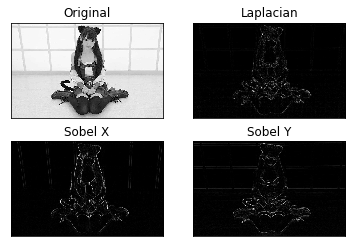

In [255]:
#cv2.CV_64F 输出图像的深度（数据类型），可以使用-1, 与原图像保持一致 np.uint8
laplacian=cv2.Laplacian(img,cv2.CV_64F)
# 参数 1,0 为只在 x 方向求一阶导数，最大可以求 2 阶导数。
sobelx=cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
# 参数 0,1 为只在 y 方向求一阶导数，最大可以求 2 阶导数。
sobely=cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(abs(laplacian),cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(abs(sobelx),cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(abs(sobely),cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

参数 -1 来设定输出图像的深度（数据类型）与原图像保持一致，  
从黑到白的边界的导数是整数，而一个从白到黑的边界点导数却是负数。如果原图像的深度是np.int8 时，所有的负值都会被截断变成 0，换句话说就是把把边界丢失掉。  
如果这两种边界都想检测到，最好的的办法就是将输出的数据类型设置的更高，比如 cv2.CV_16S， cv2.CV_64F 等。取绝对值然后再把它转回到 cv2.CV_8U

<font size='5' color='red'> 数据转换是将 数据对最大表示数取余  260（CV_64F）%256=4(uint8)

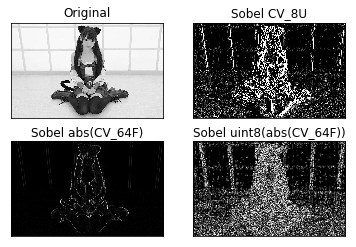

In [257]:
sobelx8u = cv2.Sobel(img,cv2.CV_8U,1,0,ksize=5)
# 也可以将参数设为-1
#sobelx8u = cv2.Sobel(img,-1,1,0,ksize=5)
# Output dtype = cv2.CV_64F. Then take its absolute and convert to cv2.CV_8U
sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
abs_sobel64f = np.absolute(sobelx64f)
sobel_8u = np.uint8(abs_sobel64f)
plt.subplot(221),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(sobelx8u,cmap = 'gray')
plt.title('Sobel CV_8U'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(abs_sobel64f,cmap = 'gray')
plt.title('Sobel abs(CV_64F)'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(sobel_8u,cmap = 'gray')
plt.title('Sobel uint8(abs(CV_64F))'), plt.xticks([]), plt.yticks([])
plt.show()

### Canny 边缘检测  ** cv2.Canny()**
Canny 边缘检测是一个有很多步构成的算法
1. **噪声去除**----------->5x5 的高斯滤波器
2. **计算图像梯度**
  Sobel 算子计算水平方向和竖直方向的一阶导数 $G_x,G_y$  $Gradient=\sqrt{G_x^2+G_y^2}$  
 梯度的方向一般总是与边界垂直。梯度方向被归为四类：垂直，水平，和两个对角线。
3. **非极大值抑制**  
对每一个像素进行检查，看这个点的梯度是不是周围具有相同梯度方向的点中最大的 **去除那些非边界上的点, 使边界变窄**
4. 滞后阈值--------->  去除小段的不是边界的点

当图像的灰度梯度高于 maxVal 时被认为是真的边界，那些低于 minVal 的边界会被抛弃。如果介于两者之间的话，就要看这个点是否与某个被确定为真正的边界点相连，如果是就认为它也是边界点，如果不是就抛弃。如下图：
<img src='canny.png' > 

A 高于阈值 maxVal 所以是真正的边界点， C 虽然低于 maxVal 但高于
minVal 并且与 A 相连，所以也被认为是真正的边界点。而 B 就会被抛弃，因
为他不仅低于 maxVal 而且不与真正的边界点相连。所以选择合适的 maxVal
和 minVal 对于能否得到好的结果非常重要。



最后一个参数是 L2gradient，它可以用来设定
求梯度大小的方程。如果设为 True，就会使用我们上面提到过的方程，否则
使用方程： Edge−Gradient (G) = jG2 xj + jG2 yj 代替，默认值为 False。

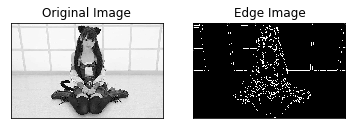

In [307]:
edges = cv2.Canny(img,70,130,5,L2gradient=True) # min 100 max 200 卷积核size 3 ,L2gradient=False
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [321]:
imdisp(edges,'canny')

## 直方图
BINS： histSize 直方图分区数
DIMS： 收集数据的参数数目， 1：灰度值
RANGE： 灰度值范围  
**cv2:calcHist(images; channels; mask; histSize; ranges[; hist[; accumulate]])**

当传入函数时应该用中括号 [] 括起来，例如： [img]  
channels:   
   灰度图： [0] 彩图： [0],[1],[2]    
mask: 掩模图像  
histSize:BIN 的数目。也应该用中括号括起来，例如： [256]。

cv2.calcHist>np.bincount>np.histogram

In [325]:
hist_opencv = cv2.calcHist([img],[0],None,[256],[0,256])# 256 bin
# numpy 方法
#img.ravel() 将图像转成一维数组，这里没有中括号。
hist_np,bins = np.histogram(img.ravel(),256,[0,256])# bins=257

hist_bc=np.bincount(img.ravel(), minlength=256)

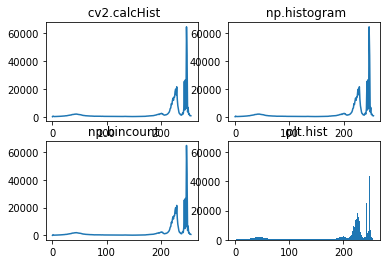

In [327]:
plt.subplot(221),plt.plot(hist_opencv),plt.title(' cv2.calcHist')
plt.subplot(222),plt.plot(hist_np),plt.title(' np.histogram')
plt.subplot(223),plt.plot(hist_bc),plt.title(' np.bincount')
plt.subplot(224),plt.hist(img.ravel(),256,[0,256]),plt.title(' plt.hist')
plt.show()

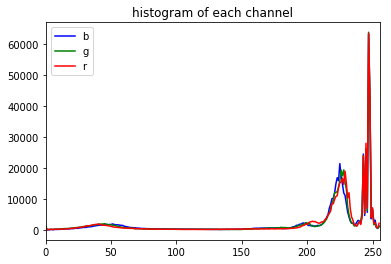

In [336]:
color = ('b','g','r')
# 对一个列表或数组既要遍历索引又要遍历元素时
# 使用内置 enumerrate 函数会有更加直接，优美的做法
#enumerate 会将数组或列表组成一个索引序列。
# 使我们再获取索引和索引内容的时候更加方便
for i,col in enumerate(color):
    histr = cv2.calcHist([img1],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.legend(color)
plt.title('histogram of each channel')
plt.show()

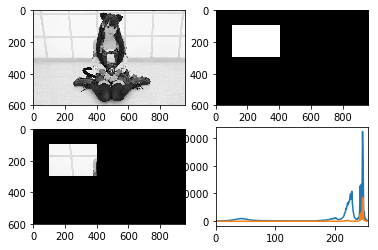

In [337]:
# create a mask
mask = np.zeros(img.shape[:2], np.uint8)
mask[100:300, 100:400] = 255
masked_img = cv2.bitwise_and(img,img,mask = mask)
# Calculate histogram with mask and without mask
# Check third argument for mask
hist_full = cv2.calcHist([img],[0],None,[256],[0,256])
hist_mask = cv2.calcHist([img],[0],mask,[256],[0,256])
plt.subplot(221), plt.imshow(img, 'gray')
plt.subplot(222), plt.imshow(mask,'gray')
plt.subplot(223), plt.imshow(masked_img, 'gray')
plt.subplot(224), plt.plot(hist_full), plt.plot(hist_mask)
plt.xlim([0,256])
plt.show()

### 直方图均衡化

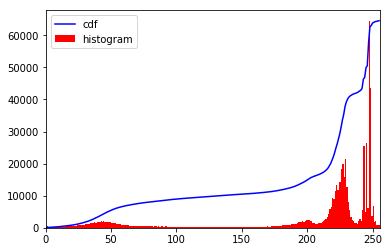

In [453]:
#flatten() 将数组变成一维
hist,bins = np.histogram(img.flatten(),256,[0,256])
# 计算累积分布图
oricdf = hist.cumsum()
oricdf_normalized = oricdf * hist.max()/ oricdf.max()
plt.plot(oricdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

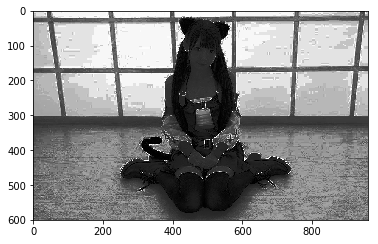

In [454]:
cdfp=np.uint8(255*oricdf.copy()/oricdf.copy().max())
im=cdfp[img]
plt.imshow(im,'gray')

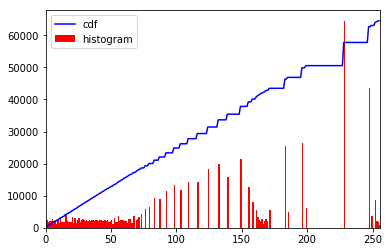

In [455]:
#flatten() 将数组变成一维
hist,bins = np.histogram(im.flatten(),256,[0,256])
# 计算累积分布图
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(im.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

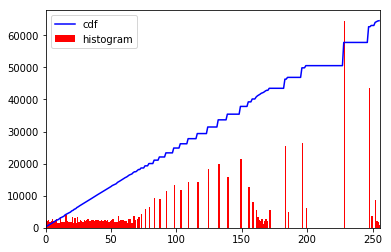

In [456]:
# 构建 Numpy 掩模数组， cdf 为原数组，当数组元素为 0 时，掩盖（计算时被忽略）。 # 将0 忽略,来去除前面很多没有值的强度值，
cdf_m = np.ma.masked_equal(oricdf.copy(),0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
# 对被掩盖的元素赋值，这里赋值为 0
cdf = np.ma.filled(cdf_m,0).astype('uint8')
img2=cdf[img]
#flatten() 将数组变成一维
hist,bins = np.histogram(img2.flatten(),256,[0,256])
# 计算累积分布图
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img2.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

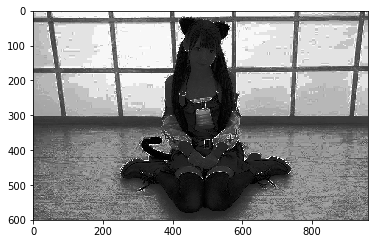

In [349]:
plt.imshow(img2,'gray')   

**(r-min)*255/(max-min) **   
<font size='5' color='red'> 这只是将图像直方图拉开到整个0-255， 不是均衡化， 其分布不是均匀分布</font>

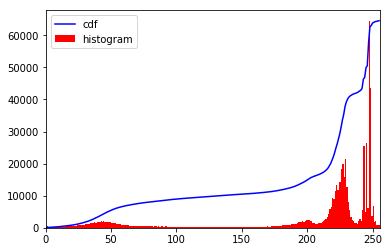

In [484]:
#####  (r-min)*255/(max-min) 
miv=np.min(img)
mav=np.max(img)
myim=np.uint8((img.copy()-miv)/(mav-miv)*255)
#flatten() 将数组变成一维
hist,bins = np.histogram(myim.flatten(),256,[0,256])
# 计算累积分布图
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(myim.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

### OpenCV 中的直方图均衡化 

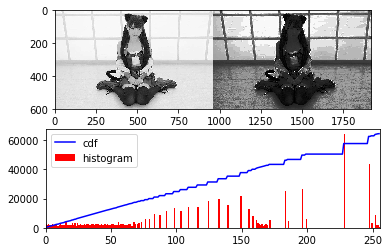

In [487]:
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ))

plt.subplot(211)
plt.imshow(res,'gray')

#flatten() 将数组变成一维
hist,bins = np.histogram(img2.flatten(),256,[0,256])
# 计算累积分布图
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()
plt.subplot(212)
plt.plot(cdf_normalized, color = 'b')
plt.hist(img2.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')

plt.show()

###  CLAHE 有限对比适应性直方图均衡化
1. 对每一个小块分别进行直方图均衡化 : 避免过曝  
2. 对比度限制： 对于每个小块来说，如果直方图中的 bin 超过对比度的上限的话，就把其中的像素点均匀分散到其他 bins 中，然后在进行直方图均衡化 **防止噪声被放大**
3. 双线性差值： 去除每一个小块之间“人造的”（由于算法造成）边界




In [491]:
help(cv2.createCLAHE)

Help on built-in function createCLAHE:

createCLAHE(...)
    createCLAHE([, clipLimit[, tileGridSize]]) -> retval
    .   @brief Creates implementation for cv::CLAHE .
    .   
    .   @param clipLimit Threshold for contrast limiting.
    .   @param tileGridSize Size of grid for histogram equalization. Input image will be divided into
    .   equally sized rectangular tiles. tileGridSize defines the number of tiles in row and column.



In [488]:
# create a CLAHE object (Arguments are optional).
# 不知道为什么我没好到 createCLAHE 这个模块
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)

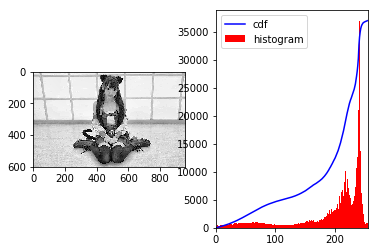

In [490]:
plt.subplot(121)
plt.imshow(cl1 ,'gray')

#flatten() 将数组变成一维
hist,bins = np.histogram(cl1.flatten(),256,[0,256])
# 计算累积分布图
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()
plt.subplot(122)
plt.plot(cdf_normalized, color = 'b')
plt.hist(cl1.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')

plt.show()